# Full data preprocessing and model training for C-GAN

In [1]:
# Traditional imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

# Music and image imports
from imageio import imwrite
from music21 import converter, instrument, note, chord, converter
from PIL import Image, ImageOps
import mido

## Preprocessing of dataset

### From image to midi file

In [7]:
# Intermediary function
def column2notes(column, lowerBoundNote = 21):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

In [8]:
# Intermediary function
def updateNotes(newNotes, prevNotes, resolution = 0.25): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

In [9]:
def image2midi(image_path, lowerBoundNote = 21, resolution = 0.25):
    """
    From an existing image:
        - Convert to notes
        - Save result as a midi file in the subfolder 'music_piece_name' of the 'data_output_sound' folder 
    """
    
    output_folder = f"../../data_output_midi/{image_path.split('/')[-2]}"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    output_filename = os.path.join(output_folder, image_path.split("/")[-1].replace(".png",".mid"))
    print(output_filename)
    
    with ImageOps.grayscale(Image.open(image_path)) as image:
        im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)
        print(im_arr.shape)
        try:
            im_arr = im_arr.reshape((image.size[1], image.size[0]))
        except:
            im_arr = im_arr.reshape((image.size[1], image.size[0],3))
            im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])
    
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{}, resolution = resolution)
    for column in im_arr.T[1:,:]:
        notes = column2notes(column, lowerBoundNote=lowerBoundNote)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)                    
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)
    
    midi_stream.write('midi', fp=output_filename)

In [10]:
# Testing the function
image_path = "../../ChopAI/data_raw/"
image2midi(image_path)

../../data_output_midi/data_raw/


FileNotFoundError: [Errno 2] No such file or directory: '../../ChopAI/data_raw/'

## From midi files, create a clean image dataset

In [11]:
def get_clean_midi_data_as_images(midi_path, output_folder_path, image_height = 106, image_length = 106):

    """
    Iterate on all midi files from the 'midi_path' folder to:
        - Keep music pieces with one piano only
        - Transform the midi file into images
        - Store all corresponding images into a 'music_piece' subfolder of the 'output_folder_path'
    """
    # Storing all midi files into a 'files_raw' list
    files_raw = [file for file in os.listdir(midi_path)]

    # Storing all midi files with only one piano in a 'files' list
    files = []
    for file in files_raw:
        try:
            mid = converter.parse(f'{midi_path}/{file}')
            file_instruments = instrument.partitionByInstrument(mid)
            if len(file_instruments)==1:
                files.append(file)
        except:
            pass

    # Iterating on all files from 'files' list to create images
    for file in files:
        file_path = f"{midi_path}/{file}"
        midi2image(file_path, output_folder_path)

In [12]:
# Testing the function
midi_path ='../../data_test/Input_midi/'
output_folder_path = '../../data_test/Input_image/'
get_clean_midi_data_as_images(midi_path, output_folder_path)

In [13]:
# Implementing the function for the entire dataset
""" midi_path ='../../data_raw/'
output_folder_path = '../../data_image/'
get_clean_midi_data_as_images(midi_path, output_folder_path) """

" midi_path ='../../data_raw/'\noutput_folder_path = '../../data_image/'\nget_clean_midi_data_as_images(midi_path, output_folder_path) "

In [14]:
def clean_images(input_path, output_path, height_image = 106, length_image = 106):
    """
    Iterate on all images created in the 'input_path' folder:
        - Resize images to height_image x length_image
        - Transform them into pure black and white images
        - Save them in a 'music piece' subfolder of the 'output_path' folder
       
    --> Input path: path to folder with input images (e.g., '../../data_test/Input_image')
    --> Output path: path to folder where we wish to save output reshaped images (e.g., '../../data_test/Input_image_cleaned')
    """
    
    for music in os.listdir(input_path):
        
        output_folder = f'{output_path}/{music}' # Creating one sub_folder for each music piece in the 'output_path' folder
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        for image in os.listdir(f"{input_path}/{music}"):
            image_path = f'{input_path}/{music}/{image}'
            image_read = Image.open(image_path) # Reading each image
            new_image = image_read.resize((106,106)) # Resizing each image
            new_image = new_image.convert("1") # Convert each image to pure black and white
            new_image.save(f'{output_folder}/{image}') # Saving each image

In [15]:
# Testing the function
clean_images('../../data_test/Input_image', '../../data_test/Input_image_cleaned')

In [16]:
# Implementing the function for the entire dataset
input_path = '../../data_image'
output_path = '../../data_image_cleaned'
clean_images(input_path, output_path)

Images to be used are now stored in the 'data_image_cleaned' folder   
Images are all of shape 106x106 and converted to pure black & white

## Get clean array dataset from clean image dataset

In [13]:
def get_pixels_array(input_path): 
    """
    Generate an array containing all images from 'input_path' folder in array format
    
    --> input_path = path of the folder containing clean images (e.g., '../../data_image_cleaned') 
    """
    
    pixels = []
    for music in os.listdir(input_path):
        for image in os.listdir(f"{input_path}/{music}"):
            image_path = f'{input_path}/{music}/{image}'
            image_read = Image.open(image_path) # Reading each image
            pixels_image = np.array(image_read.getdata()).astype('float32') # Store all pixel values in an array, each i_th-sequence contains the values of pixels in a i_th-row
            pixels_image = pixels_image / 255.0 # All the values are 0 (black) and white (255). Normalize pixel values to be between 0 and 1
            pixels.append(pixels_image.reshape(106, 106,1)) # Reshape pixels to be a matrix

    pixels = np.array(pixels)
    
    return pixels

In [17]:
# Implementing the function for the entire dataset
input_path = '../../data_image_cleaned'
pixels = get_pixels_array(input_path)
pixels.shape

(1507, 106, 106, 1)

In [19]:
def show_image_from_pixels(pixels_matrix, image_number):
    """
    Given a pixel matrix representing a dataset, get representation of one image (number image_number)
    """
    plt.imshow(np.squeeze(pixels_matrix[image_number, :, :, :]))
    plt.show()

## 

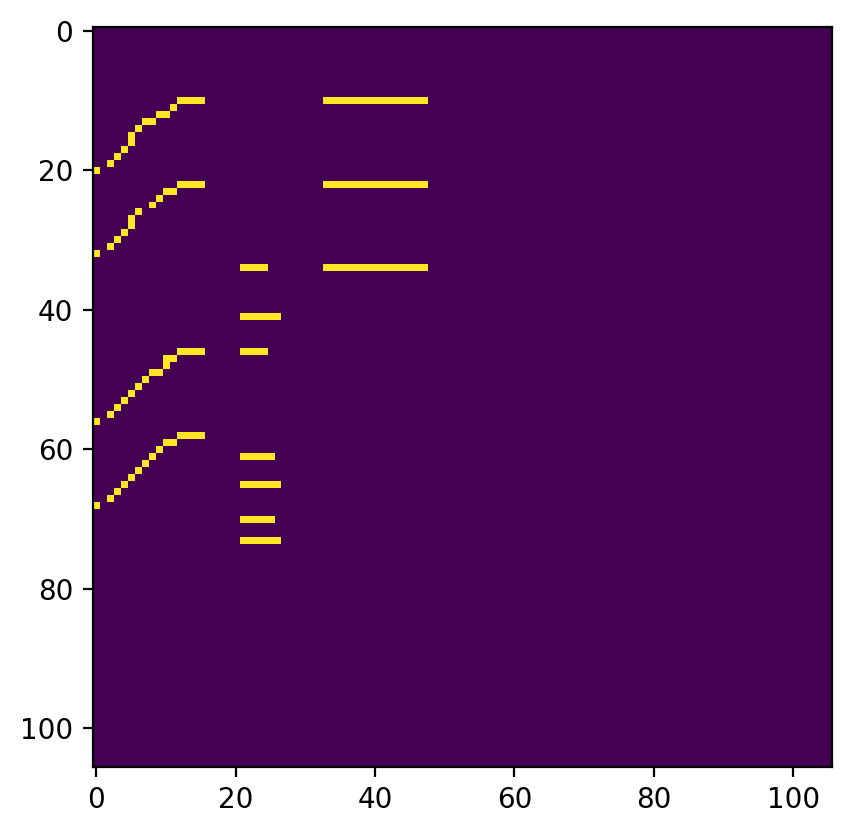

In [22]:
show_image_from_pixels(pixels, 100)

Dataset is now given in the form of a matrix containing 1507 images of shape 106 x 106

## Model

In [41]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,Dense, Reshape, Flatten, BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model

### Defining Discriminator

In [37]:
image_height = 106
image_length = 106

In [38]:
# Define the standalone discriminator model
def def_discriminator(in_shape=(image_height,image_length,1)): # Input is an image of shape 106 x 106 in black and white
    """
    Returns a compiled discriminator model
    """
 
    # Define inputs
    inputs = Input(in_shape)
    
    # Block 1
    convolutional_layer_1 = Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=in_shape) (inputs)
    activation_1 = LeakyReLU(alpha=0.2) (convolutional_layer_1)
    dropout_1 = Dropout(0.5) (activation_1)
    
    # Block 2
    convolutional_layer_2 = Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=in_shape) (dropout_1)
    activation_2 = LeakyReLU(alpha=0.2) (convolutional_layer_2)
    dropout_2 = Dropout(0.5) (activation_2)
    
    # Classifier
    flattened_layer = Flatten()(dropout_2)
    batch_normalization_layer = BatchNormalization()(flattened_layer)
    output_discriminator = Dense(1, activation="sigmoid")(batch_normalization_layer)
    
    # Defining discrimnator model
    model = Model(inputs, outputs = output_discriminator)
    
    # Compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
    
    return model

In [39]:
discriminator_model = def_discriminator()
discriminator_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 106, 106, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 53, 53, 64)        640       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 53, 53, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 53, 53, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 27, 27, 64)        36928     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 27, 27, 64)        0         
                                                                 
 dropout_9 (Dropout)         (None, 27, 27, 64)        0   

### Defining Generator

In [40]:
latent_dimension = 100

In [43]:
# Define the standalone generator model
def def_generator(in_shape = latent_dimension):
    """
    Returns a generator model WITHOUT compiling it
    """
    # Defining inputs
    inputs = Input(in_shape)
    
    # Block 1 - foundation for 53 x 53 images
    n_nodes_1 = 128 * 53 * 53
    dense_1 = Dense(n_nodes_1, input_dim=latent_dimension)(inputs)
    activation_1 = LeakyReLU(alpha=0.2)(dense_1)
    reshape_layer = Reshape( (53,53,128))(activation_1)
    
    # Block 2
    dense_2 = Dense(1024)(reshape_layer)
    conv2d_transposed_layer_1 = Conv2DTranspose(1024,(4,4), strides=(2,2), padding="same")(dense_2)
    
    # Block 3
    dense_3 = Dense(1024)(conv2d_transposed_layer_1)
    activation_2 = LeakyReLU(alpha=0.2)(dense_3)
    dense_4 = Dense(1024)(activation_2)
    conv2d_transposed_layer_1 = Conv2DTranspose(1,(7,7), padding="same", activation='sigmoid')(dense_4)
    
    # Generate model
    model = Model(inputs, outputs=conv2d_transposed_layer_1)
    
    return model

In [44]:
generator_model = def_generator()
generator_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_5 (Dense)             (None, 359552)            36314752  
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 359552)            0         
                                                                 
 reshape (Reshape)           (None, 53, 53, 128)       0         
                                                                 
 dense_6 (Dense)             (None, 53, 53, 1024)      132096    
                                                                 
 conv2d_transpose (Conv2DTr  (None, 106, 106, 1024)    16778240  
 anspose)                                                        
                                                           

### Defining GAN

In [45]:
# Define the combined generator and discriminator model, for updating the generator
def def_gan(generator, discriminator):
    """
    Returns a compiled GAN model
    """
    # Make weights in the discriminator not trainable - train only generator weights
    discriminator.trainable = False
    
    # Instantiate GAN model
    model = Sequential()
    
    # Add generator and discrimnator
    model.add(generator)
    model.add(discriminator)
    
    # Compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt)
    
    return model

In [47]:
gan_model = def_gan(generator_model, discriminator_model)
gan_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 106, 106, 1)       55374465  
                                                                 
 model_1 (Functional)        (None, 1)                 270849    
                                                                 
Total params: 55645314 (212.27 MB)
Trainable params: 55374465 (211.24 MB)
Non-trainable params: 270849 (1.03 MB)
_________________________________________________________________


### Training GAN

We will require one batch (or a half) batch of real images from the dataset for each update to the GAN model. A simple way to achieve this is to select a random sample of images from the dataset each time.

In [71]:
# Select a sample of 'real' images
def generate_real_samples(dataset, n_samples):
    """
    Takes as input cleaned dataset and a number of samples to be generated
    Returns a random sample of n_samples images and their corresponding label (=1 because these are real images)
    """
    # Choose random instances (i.e., randomly select n_samples indexes from dataset)
    iX = np.random.randint(0, pixels.shape[0], n_samples)
    # Loading corresponding images
    X = pixels[iX]
    # Creating corresponding 'Real' (=1) labels
    y = np.ones((n_samples, 1)) 
    
    return X, y

Inputs for the generator model are random points from latent space corresponding to a Gaussian distributed variable

In [72]:
# Generate points in latent space as input for the generator, following Gaussian distributed variable
def generate_latent_points(latent_dim, n_samples):
    # Generate (latent dimension x n_samples) array of random values taken from x axis of Normal Distribution
    x_input = np.random.randn(latent_dim*n_samples)
    # Reshape to have num_samples entries for each one with latent_dimension values
    x_input = x_input.reshape(n_samples, latent_dimension)
    return x_input

In [73]:
# Use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # Generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # Predict outputs
    X = generator.predict(x_input)
    # Generate corresponding 'Fake' (=0) class labels
    y = np.zeros((n_samples, 1))
    return X, y

In [78]:
# Training parameters
n_epochs = 250
n_batch = 15

In [79]:
# Custom function to display accuracy of the Discriminator in preidtcing correctly both real and fake music samples
def show_current_discriminator_accuracy(discriminator_model, generator_model, pixels, latent_dimension = latent_dimension):
    num_samples_to_test = 100
    
    #generate real music samples
    X_real, y_real = generate_real_samples(pixels, num_samples_to_test)
  
    #generate fake music samples
    X_fake, y_fake = generate_fake_samples(generator_model, latent_dimension, num_samples_to_test)
    
    #evaluate the accuracy of the discriminator on real music samples
    _, accuracy_on_real = discriminator_model.evaluate(X_real, y_real, verbose=0)
    #evaluate the accuracy of the discriminator on fake music samples
    _, accuracy_on_fake = discriminator_model.evaluate(X_fake, y_fake, verbose=0)

    #print results
    print("   Current accuracy of the discriminator on real music samples:", round(accuracy_on_real*100,3),"%")
    print("   Current accuracy of the discriminator on fake music samples:", round(accuracy_on_fake*100,3),"% \n")

    return accuracy_on_real, accuracy_on_fake

In [80]:
# Train the GAN model
def train(generator_model, discriminator_model, gan_model, dataset, latent_dim = latent_dimension, n_epochs=n_epochs, n_batch=n_batch):
    bat_per_epo = int(dataset.shape[0] / n_batch) # Number of batches per epoch
    half_batch = int(n_batch / 2) # Half the number of batches 
    
    # Storing results along the epochs
    # Dataframe containing loss and accuracy for each epoch
    discriminator_info_per_epoch = pd.DataFrame(columns=['loss_discriminator_on_real_music', 'loss_generator_on_fake_music', 'accuracy_on_real', 'accuracy_on_fake'])
    
    accuracy_on_fake = 0
    accuracy_on_real = 0
    
    # For each epoch
    for i in range(n_epochs): # Enumerate epochs
        
        # For each batch
        for j in range(bat_per_epo):
 
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = discriminator_model.train_on_batch(X_real, y_real)
            
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = discriminator_model.train_on_batch(X_fake, y_fake)
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

        # print the current accuracy obtained in classifing correctly both real music samples and fake music samples (the ones generated by the generator)
        accuracy_on_real, accuracy_on_fake = show_current_discriminator_accuracy(discriminator_model, generator_model, pixels, latent_dimension)
        discriminator_info_per_epoch = discriminator_info_per_epoch.append({'loss_discriminator_on_real_music':  d_loss1, 'loss_generator_on_fake_music': g_loss, 'accuracy_on_real': accuracy_on_real, 'accuracy_on_fake': accuracy_on_fake}, ignore_index=True)
        
    return gan_model, discriminator_info_per_epoch

In [81]:
train(generator_model, discriminator_model, gan_model, pixels)

1/1 [==============================] - 8s 8s/step


KeyboardInterrupt: 